In [1]:
import pandas as pd
import numpy as np
import copy
import warnings
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.model_selection import train_test_split
from PIL import Image 
import random
warnings.filterwarnings("ignore")
from tqdm import tqdm
import string

import torch
from torch import nn
from transformers import AutoTokenizer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

# Behaviors

In [2]:
behaviors = pd.read_csv('/kaggle/input/mind-news-dataset/MINDsmall_train/behaviors.tsv',header=None,sep='\t')

In [3]:
behaviors.head()

,0,1,2,3,4
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


The behaviors.tsv file contains the impression logs and users' news click hostories. It has 5 columns divided by the tab symbol:

* **Impression ID** - The ID of an impression.
* **User ID** - The anonymous ID of a user.
* **Time** - The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
* **History** - The news click history (ID list of clicked news) of this user before this impression. The clicked news articles are ordered by time.
* **Impressions** - List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click). The orders of news in a impressions have been shuffled.

In [4]:
behaviors.columns=['Impression ID',
"User ID",
"Time",
"History",
"Impressions"]

# News

It has 7 columns, which are divided by the tab symbol:

* **News ID**
* **Category**
* **SubCategory**
* **Title**
* **Abstract**
* **URL**
* **Title Entities** (entities contained in the title of this news)
* **Abstract Entities** (entites contained in the abstract of this news)

In [5]:
news = pd.read_csv('/kaggle/input/mind-news-dataset/news.tsv/news.tsv',header=None,sep='\t')

In [6]:
news.head()

,0,1,2,3,4,5,6,7
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [7]:
news.columns=['News ID',
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities",
"Abstract Entities"]

# Selecting columns

In [8]:
news = news.iloc[:,:5]

# Visualization

## Category and SubCategory

In [9]:
c = news[['Category','SubCategory']].value_counts()

index = []
for i in c.index:
    index.append(np.array(i))
index = np.array(index)

df = pd.DataFrame(columns=['Category','Sub Category','Values'])
df['Category'] = index[:,0]
df['Sub Category'] = index[:,1]
df['Values'] = c.values

In [10]:
px.bar(data_frame=df,x='Category',y='Values',color='Sub Category')

### WordCloud News

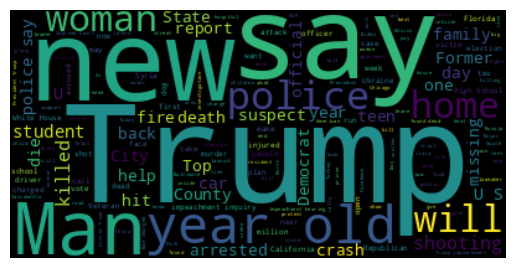

In [16]:
text=' '
for i in news[news['Category']=='news']['Title']:
    text+=i+' '
    
# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

### NewsUS

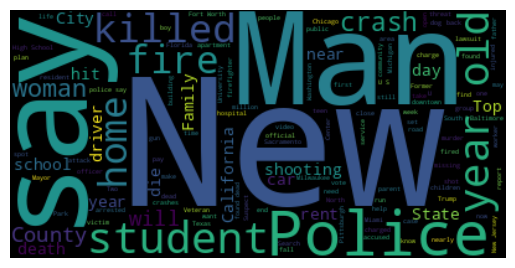

In [17]:
text=' '
for i in news[(news['Category']=='news')
             & (news['SubCategory']=='newsus')]['Title']:
    text+=i+' '
    
# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

### NewsPolitics

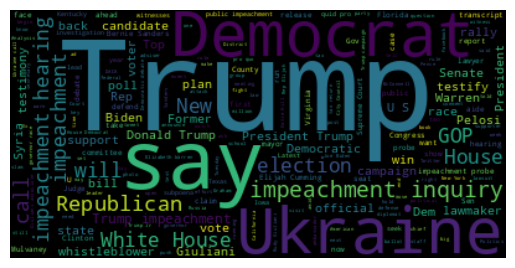

In [18]:
text=' '
for i in news[(news['Category']=='news')
             & (news['SubCategory']=='newspolitics')]['Title']:
    text+=i+' '
    
# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

### NewsWorld

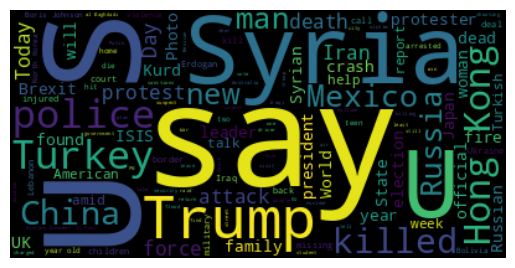

In [19]:
text=' '
for i in news[(news['Category']=='news')
             & (news['SubCategory']=='newsworld')]['Title']:
    text+=i+' '
    
# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

# Sport

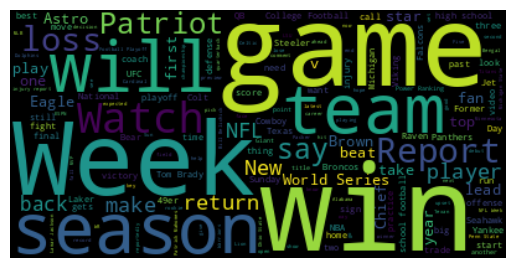

In [20]:
text=' '
for i in news[(news['Category']=='sports')]['Title']:
    text+=i+' '
    
# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

# Data Preprocessing

## Removing all the duplicate values

In [11]:
print('the number of articles before processing :',len(news))
news.drop_duplicates(subset=['Title'],inplace=True)
print('The number of articles after processing :',len(news))

the number of articles before processing : 51282
The number of articles after processing : 50434


## NaN values

In [12]:
news.isna().sum()

News ID           0
Category          0
SubCategory       0
Title             0
Abstract       2646
dtype: int64

In [13]:
news.dropna(inplace=True)

## Titles length

In [24]:
news['Title_Length'] = news['Title'].apply(len)

title_length_counts = news['Title_Length'].value_counts()

for length, count in title_length_counts.items():
    print(f'Title Length {length}: {count} occurrences')

Title Length 60: 1375 occurrences
Title Length 59: 1289 occurrences
Title Length 58: 1224 occurrences
Title Length 57: 1210 occurrences
Title Length 64: 1092 occurrences
Title Length 63: 1091 occurrences
Title Length 62: 1080 occurrences
Title Length 56: 1066 occurrences
Title Length 55: 1055 occurrences
Title Length 65: 1032 occurrences
Title Length 61: 1023 occurrences
Title Length 54: 1011 occurrences
Title Length 70: 1000 occurrences
Title Length 69: 990 occurrences
Title Length 67: 986 occurrences
Title Length 68: 973 occurrences
Title Length 66: 966 occurrences
Title Length 71: 882 occurrences
Title Length 53: 872 occurrences
Title Length 52: 871 occurrences
Title Length 72: 863 occurrences
Title Length 73: 818 occurrences
Title Length 50: 798 occurrences
Title Length 51: 786 occurrences
Title Length 76: 760 occurrences
Title Length 75: 757 occurrences
Title Length 49: 754 occurrences
Title Length 77: 748 occurrences
Title Length 74: 734 occurrences
Title Length 79: 714 occurrenc

In [25]:
titles_smaller_than_10 = (news['Title_Length'] < 10).sum()
print(f'Titles with length smaller than 10: {titles_smaller_than_10}')

Titles with length smaller than 10: 0


# Sentiment Analyses
https://huggingface.co/bert-base-uncased

In [41]:
bert_uncased_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [42]:
class BertBaseDataset(Dataset):
    def __init__(self, tokenizer, df, text_col, max_len):
        self.tokenizer = tokenizer
        self.texts = df[text_col].values.tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        res = self.tokenizer(
            self.texts[idx],
            return_tensors="pt",
            padding=False,
            truncation=True,
            # return_special_tokens_mask=True,
            max_length=self.max_len,
        )
        res = {k:v[0] for k,v in res.items()}
        return res
    
def dynamic_pad_data_loader(tokenizer, dataset, batch_size, shuffle):
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=data_collator
    )

In [40]:
backbone = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(backbone)

ds = BertBaseDataset(tokenizer, news, "Title", 200)
dl = dynamic_pad_data_loader(tokenizer, ds, batch_size=32, shuffle=False)

In [44]:
model = AutoModelForSequenceClassification.from_pretrained(backbone)
model.eval()

preds = []

with torch.no_grad(), tqdm(total=len(dl)) as pbar:
    for batch in dl:
        output = model(**batch)
        preds.append(output["logits"])
        pbar.update(1)

# Concatenate the logits from all batches
preds = torch.cat(preds, dim=0)

print("Shape of all logits:", preds.shape)

100%|██████████| 1494/1494 [31:35<00:00,  1.27s/it]

Shape of all logits: torch.Size([47788, 5])


In [47]:
preds

tensor([[-0.1998, -0.7359, -0.2416,  0.0474,  0.9556],
        [ 2.6585,  0.9161, -0.4352, -1.7398, -0.9624],
        [ 0.4774,  0.1361, -0.2884, -0.1884, -0.1670],
        ...,
        [-2.1947, -1.7080,  0.0687,  1.5825,  1.6135],
        [ 0.6492,  0.1956,  0.1590, -0.2491, -0.7427],
        [-1.3616, -1.5732, -0.5012,  0.9772,  1.9645]])

In [49]:
preds = preds.softmax(1).numpy()
preds_df = pd.DataFrame(preds, columns=[f"{i+1} stars" for i in range(5)])
preds_df["predicted stars"] = preds.argmax(axis=1) + 1
preds_df.insert(0, "Title", news['Title'])
preds_df.insert(0, "News ID", news['News ID'])
preds_df.head()

,'News ID',Title,1 stars,2 stars,3 stars,4 stars,5 stars,predicted stars
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an...",0.142856,0.083573,0.137006,0.182925,0.453640,5
1,N19639,50 Worst Habits For Belly Fat,0.793975,0.139021,0.035994,0.009765,0.021246,1
2,N61837,The Cost of Trump's Aid Freeze in the Trenches...,0.311068,0.221129,0.144643,0.159846,0.163315,1
3,N53526,I Was An NBA Wife. Here's How It Affected My M...,0.068554,0.096584,0.171882,0.241879,0.421101,5
4,N38324,"How to Get Rid of Skin Tags, According to a De...",0.041962,0.048098,0.133617,0.377705,0.398618,5


In [52]:
csv_path = "/kaggle/working/preds.csv"

# Save the DataFrame to a CSV file
preds_df.to_csv(csv_path, index=False)

In [20]:
preds = pd.read_csv('/kaggle/input/pred-sentiment/preds.csv')

In [28]:
preds.head()

,News ID,Title,1 stars,2 stars,3 stars,4 stars,5 stars,predicted stars
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an...",0.142856,0.083573,0.137006,0.182925,0.453640,5
1,N19639,50 Worst Habits For Belly Fat,0.793975,0.139021,0.035994,0.009765,0.021246,1
2,N61837,The Cost of Trump's Aid Freeze in the Trenches...,0.311068,0.221129,0.144643,0.159846,0.163315,1
3,N53526,I Was An NBA Wife. Here's How It Affected My M...,0.068554,0.096584,0.171882,0.241879,0.421101,5
4,N38324,"How to Get Rid of Skin Tags, According to a De...",0.041962,0.048098,0.133617,0.377705,0.398618,5


In [29]:
news.head()

,News ID,Category,SubCategory,Title,Abstract
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re..."


In [34]:
merged = pd.merge(preds, news[["News ID", "Category", "SubCategory", "Abstract"]], on="News ID", how="inner")

csv_path = "/kaggle/working/merged.csv"
merged.to_csv(csv_path, index=False)

In [35]:
merged.head()

,News ID,Title,1 stars,2 stars,3 stars,4 stars,5 stars,predicted stars,Category,SubCategory,Abstract
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an...",0.142856,0.083573,0.137006,0.182925,0.453640,5,lifestyle,lifestyleroyals,"Shop the notebooks, jackets, and more that the..."
1,N19639,50 Worst Habits For Belly Fat,0.793975,0.139021,0.035994,0.009765,0.021246,1,health,weightloss,These seemingly harmless habits are holding yo...
2,N61837,The Cost of Trump's Aid Freeze in the Trenches...,0.311068,0.221129,0.144643,0.159846,0.163315,1,news,newsworld,Lt. Ivan Molchanets peeked over a parapet of s...
3,N53526,I Was An NBA Wife. Here's How It Affected My M...,0.068554,0.096584,0.171882,0.241879,0.421101,5,health,voices,"I felt like I was a fraud, and being an NBA wi..."
4,N38324,"How to Get Rid of Skin Tags, According to a De...",0.041962,0.048098,0.133617,0.377705,0.398618,5,health,medical,"They seem harmless, but there's a very good re..."


# Results evaluation

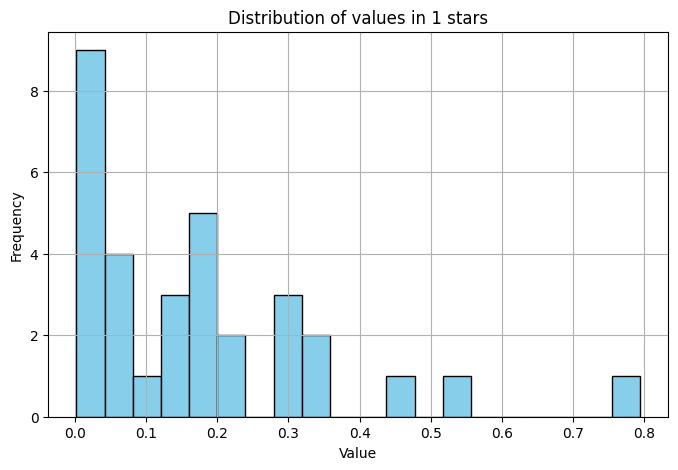

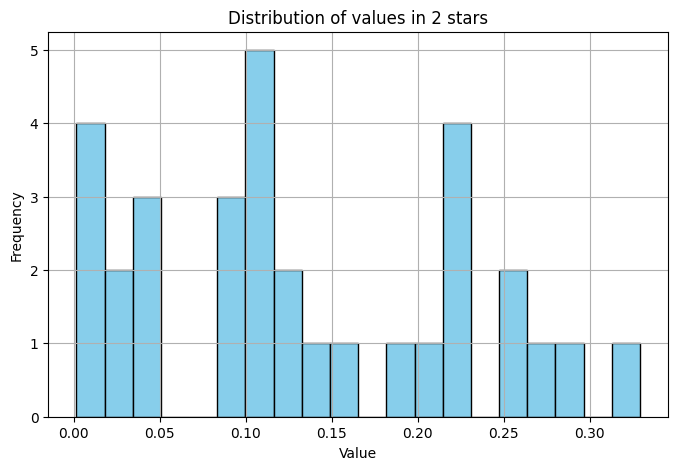

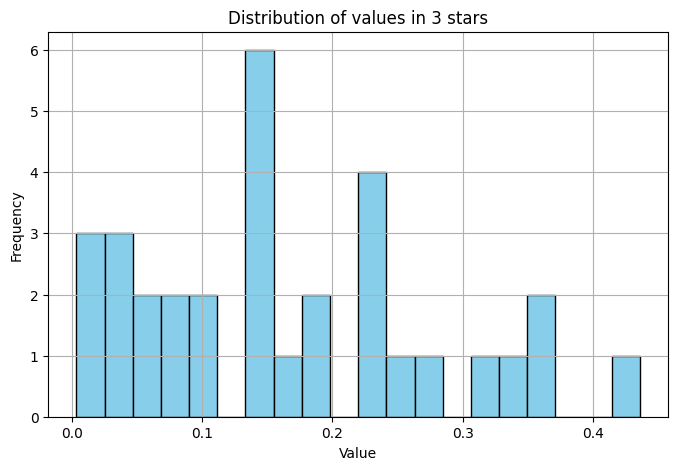

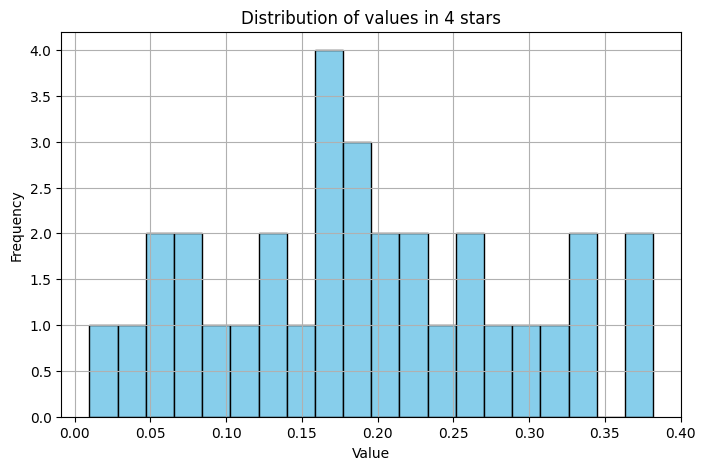

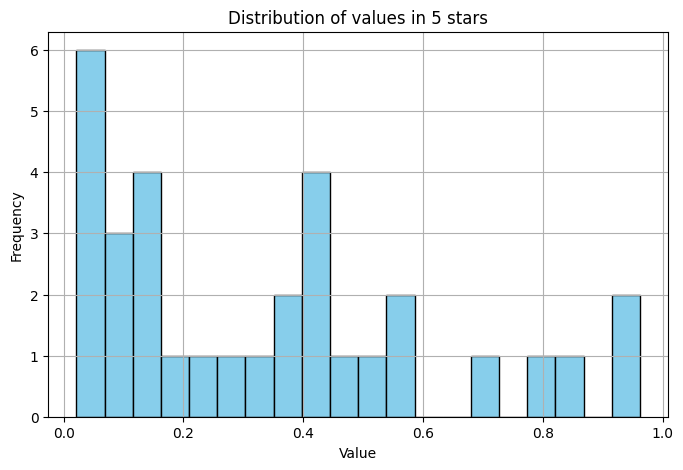

In [39]:
# Extract stars columns for plotting
stars_columns = ['1 stars', '2 stars', '3 stars', '4 stars', '5 stars']

for column in stars_columns:
    plt.figure(figsize=(8, 5))
    plt.hist(df[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of values in {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

## WorldCloud pro jednotlive sentimenty

negativity 1


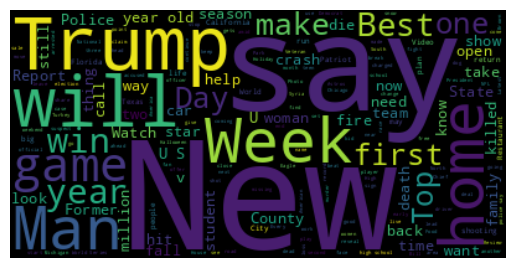

negativity 2


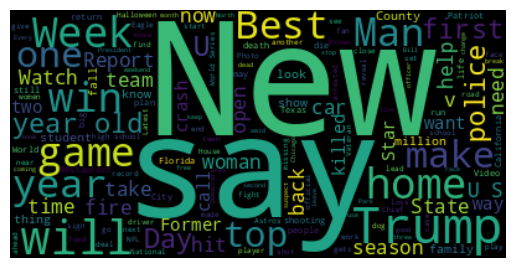

negativity 3


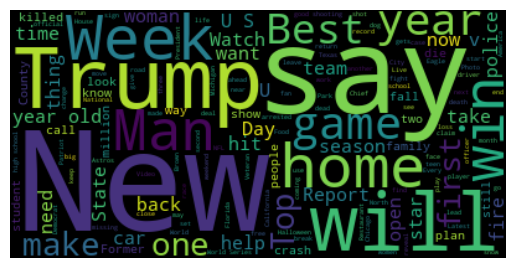

negativity 4


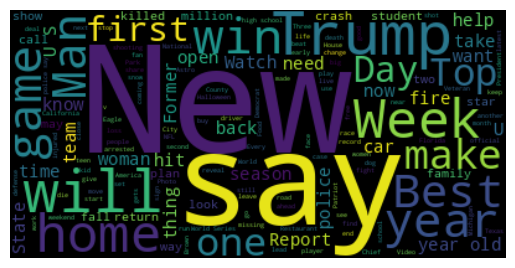

negativity 5


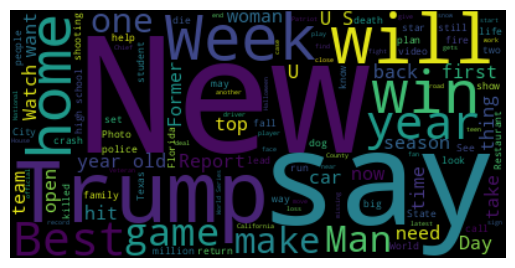

In [42]:
text=' '
unique_predicted_stars = np.sort(preds['predicted stars'].unique())
for predicted_star in unique_predicted_stars:
    filtered_preds = preds[preds['predicted stars'] == predicted_star]
    for title in filtered_preds['Title']:
        text+=str(title)+' '
    
    # Make the figure
    wordcloud = WordCloud().generate(text)
    print(f"negativity {predicted_star}")
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    plt.show()

## WorldCloud pro titulky obsahující slovo Trump

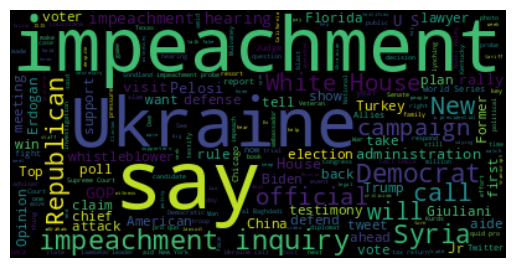

In [27]:
text=' '
words_not_use = ['Trump',"Trump's","trump's", 'trump', 'Donald',"Donald's", 'donald',"donald's", 'President','president', 'usa', 'us', 'USA', 'US']
for sentence in preds[preds['Title'].str.contains('Trump|trump', case=False, na=False)]['Title']:
    for word in [word.strip(string.punctuation) for word in sentence.split()]: 
        if not word in words_not_use:
            text+=word+' '
    
# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

###  WorldCloud pro titulky o Trumpovi pro kazdou hodnotu sentimentu

negativity 1


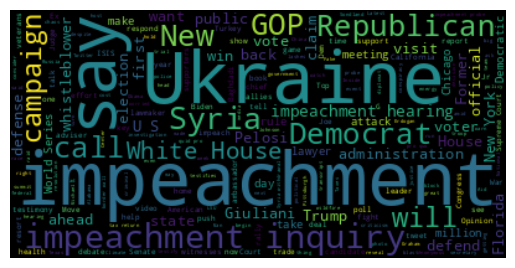

negativity 2


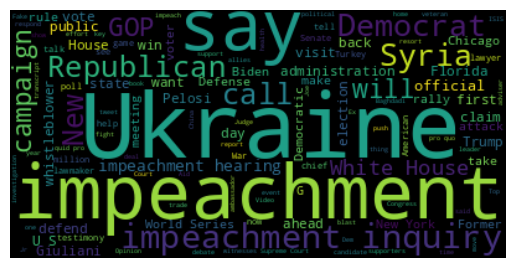

negativity 3


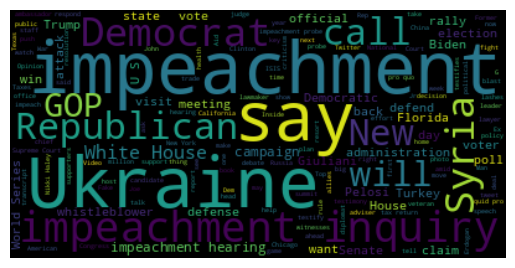

negativity 4


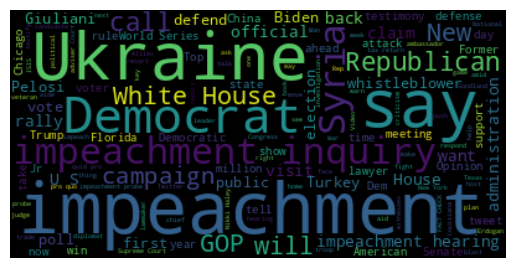

negativity 5


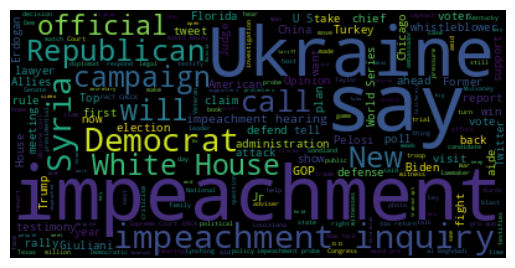

In [36]:
text=' '
words_not_use = ['Trump',"Trump's","trump's", 'trump', 'Donald',"Donald's", 'donald',"donald's", 'President','president', 'usa', 'us', 'USA', 'US']

unique_predicted_stars = np.sort(preds['predicted stars'].unique())
for predicted_star in unique_predicted_stars:
    filtered_preds = preds[preds['predicted stars'] == predicted_star]
    for sentence in filtered_preds[filtered_preds['Title'].str.contains('Trump|trump', case=False, na=False)]['Title']:
        for word in [word.strip(string.punctuation) for word in sentence.split()]: 
            if not word in words_not_use:
                text+=word+' '
    
    # Make the figure
    wordcloud = WordCloud().generate(text)
    print(f"negativity {predicted_star}")
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    plt.show()

## Category a SubCategory podle sentimentu

In [38]:
for stars in range(1, 6):
    total_count = len(merged[merged['predicted stars'] == stars])
    top_categories = merged[merged['predicted stars'] == stars]['Category'].value_counts().nlargest(10)
    top_categories_percentage = (top_categories / total_count) * 100
    print(f'Top 10 categories for {stars} stars (percentage of total count):')
    print(top_categories_percentage)
    print('\n')

Top 10 categories for 1 stars (percentage of total count):
Category
news            32.382589
sports          25.733104
finance          6.557847
foodanddrink     5.183276
lifestyle        4.759450
travel           4.381443
video            4.255441
health           3.808706
weather          3.757159
autos            3.247423
Name: count, dtype: float64


Top 10 categories for 2 stars (percentage of total count):
Category
news            32.005495
sports          26.373626
finance          5.494505
foodanddrink     5.425824
travel           4.670330
lifestyle        4.464286
video            4.189560
autos            3.846154
health           3.846154
weather          3.090659
Name: count, dtype: float64


Top 10 categories for 3 stars (percentage of total count):
Category
news            30.764840
sports          26.826484
finance          6.621005
foodanddrink     5.707763
lifestyle        5.051370
travel           4.423516
video            4.252283
health           4.166667
weather 

In [40]:
news_df = merged[merged['Category'] == 'news']

# Print top 10 SubCategory values as a percentage for each predicted stars value
for stars in range(1, 6):
    total_count = len(news_df[news_df['predicted stars'] == stars])
    top_subcategories = news_df[news_df['predicted stars'] == stars]['SubCategory'].value_counts().nlargest(10)
    top_subcategories_percentage = (top_subcategories / total_count) * 100
    print(f'Top 10 SubCategories for {stars} stars (percentage of total count):')
    print(top_subcategories_percentage)
    print('\n')

Top 10 SubCategories for 1 stars (percentage of total count):
SubCategory
newsus                      40.767598
newspolitics                18.287938
newscrime                   14.697559
newsworld                   10.718076
newsscienceandtechnology     7.905907
newsoffbeat                  2.405377
newsopinion                  2.016272
newsgoodnews                 1.467987
elections-2020-us            0.495225
newsbusiness                 0.336045
Name: count, dtype: float64


Top 10 SubCategories for 2 stars (percentage of total count):
SubCategory
newsus                      41.201717
newspolitics                18.240343
newscrime                   16.952790
newsworld                   10.515021
newsscienceandtechnology     7.296137
newsoffbeat                  2.575107
newsopinion                  1.716738
elections-2020-us            0.643777
newsfactcheck                0.214592
newsrealestate               0.214592
Name: count, dtype: float64


Top 10 SubCategories for 3 stars